In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm

In [2]:
# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../scripts')

Missing values in the dataset:
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


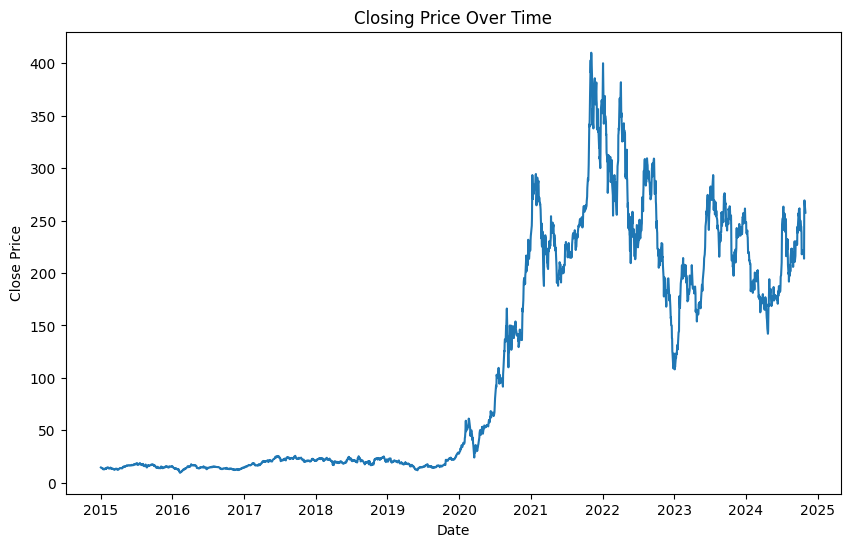

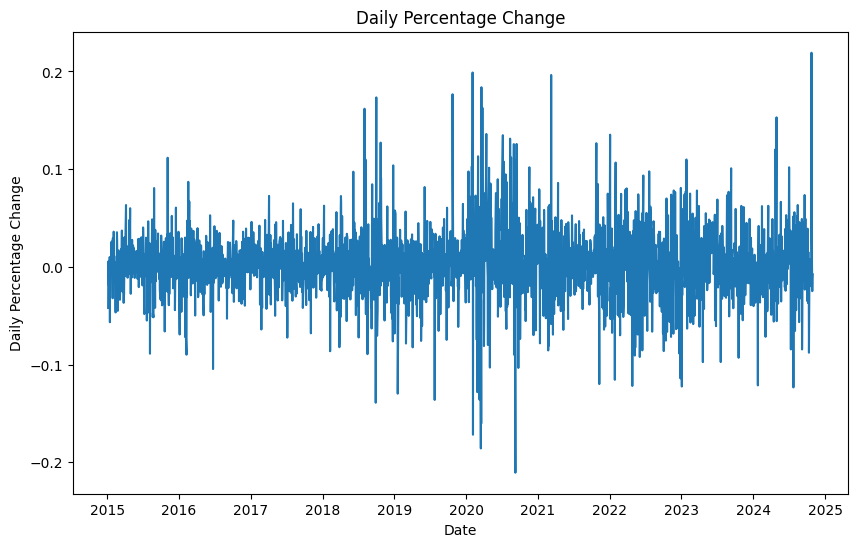

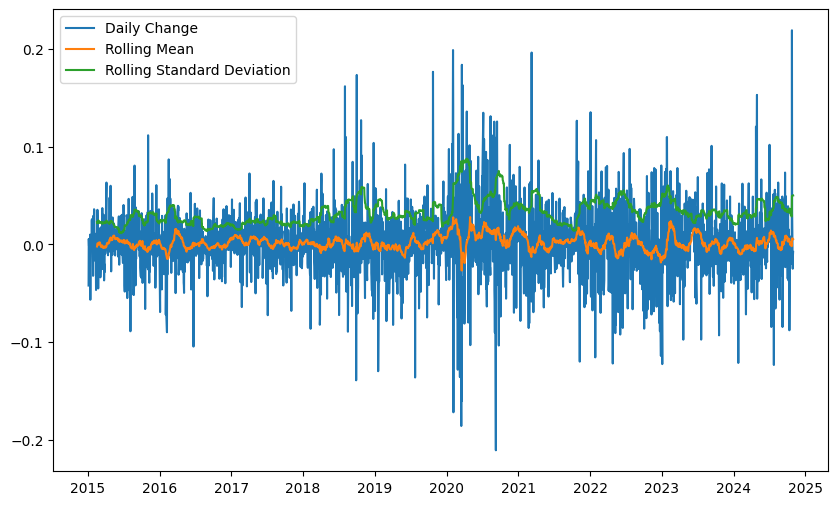

In [4]:
# Load the cleaned dataset
tsla_data = pd.read_csv('../data/cleaned_TSLA_data.csv')

# Convert the 'Date' column to datetime format
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])

# Set the 'Date' column as the index
tsla_data.set_index('Date', inplace=True)

# Check for missing values
print("Missing values in the dataset:")
print(tsla_data.isnull().sum())

# Plot the closing price over time
plt.figure(figsize=(10, 6))
plt.plot(tsla_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Closing Price Over Time')
plt.show()

# Calculate and plot the daily percentage change
daily_change = tsla_data['Close'].pct_change()

plt.figure(figsize=(10, 6))
plt.plot(daily_change)
plt.xlabel('Date')
plt.ylabel('Daily Percentage Change')
plt.title('Daily Percentage Change')
plt.show()

# Analyze volatility by calculating rolling means and standard deviations
rolling_mean = daily_change.rolling(window=30).mean()
rolling_std = daily_change.rolling(window=30).std()

plt.figure(figsize=(10, 6))
plt.plot(daily_change, label='Daily Change')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Standard Deviation')
plt.legend()
plt.show()

In [5]:
# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data)
    if result[1] <= 0.05:
        print('The data is stationary.')
    else:
        print('The data is not stationary.')

check_stationarity(tsla_data['Close'])

The data is not stationary.


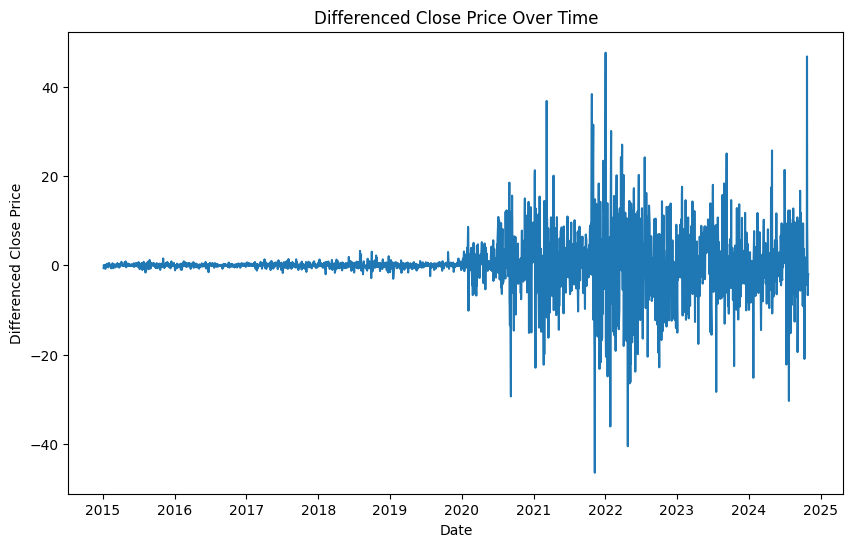

The data is stationary.


In [6]:
tsla_data_diff = tsla_data['Close'].diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(tsla_data_diff)
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.show()

# Check for stationarity using Augmented Dickey-Fuller test
def check_stationarity(data):
    result = adfuller(data)
    if result[1] <= 0.05:
        print('The data is stationary.')
    else:
        print('The data is not stationary.')

check_stationarity(tsla_data_diff)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1978
Model:                        SARIMAX   Log Likelihood               -6168.668
Date:                Sat, 09 Nov 2024   AIC                          12339.337
Time:                        14:52:30   BIC                          12344.927
Sample:                             0   HQIC                         12341.391
                               - 1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        29.9462      0.322     92.906      0.000      29.314      30.578
Ljung-Box (L1) (Q):                   3.03   Jarque-Bera (JB):             19743.15
Prob(Q):                              0.08   Pr

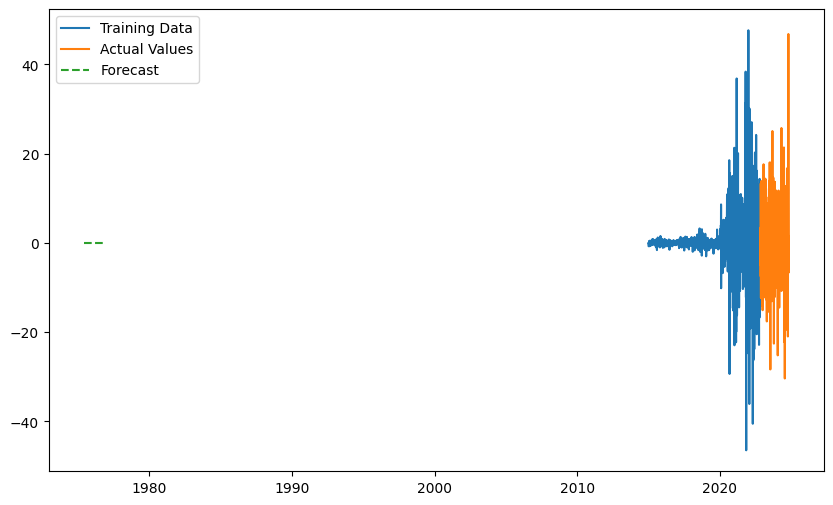

In [12]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Split the data into training and testing sets
train_size = int(0.8 * len(tsla_data_diff))
train_data, test_data = tsla_data_diff[0:train_size], tsla_data_diff[train_size:len(tsla_data_diff)]

# Optimize the model parameters using auto_arima
model = auto_arima(train_data, start_p=1, start_d=1, start_q=1,
                   max_p=3, max_d=2, max_q=3, start_P=0, seasonal=True)

# Print the optimized parameters
print(model.summary())

# Create a SARIMA model with the optimized parameters
sarima_model = SARIMAX(train_data, order=model.order, seasonal_order=model.seasonal_order)

# Fit the model
sarima_model_fit = sarima_model.fit()

# Generate forecasts for the test data
forecast = sarima_model_fit.forecast(steps=len(test_data))

# Evaluate the model
mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mape = mean_absolute_percentage_error(test_data, forecast)

print('MAE: ', mae)
print('RMSE: ', rmse)
print('MAPE: ', mape)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Values')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.legend()
plt.show()

# Save the trained model
sarima_model_fit.save('../models/sarima_model.pkl')

### ARIMA MODEL

ARIMA Model Metrics:
MAE:  9.99141000963953
RMSE:  11.842598981524436
MAPE:  82031389639152.81


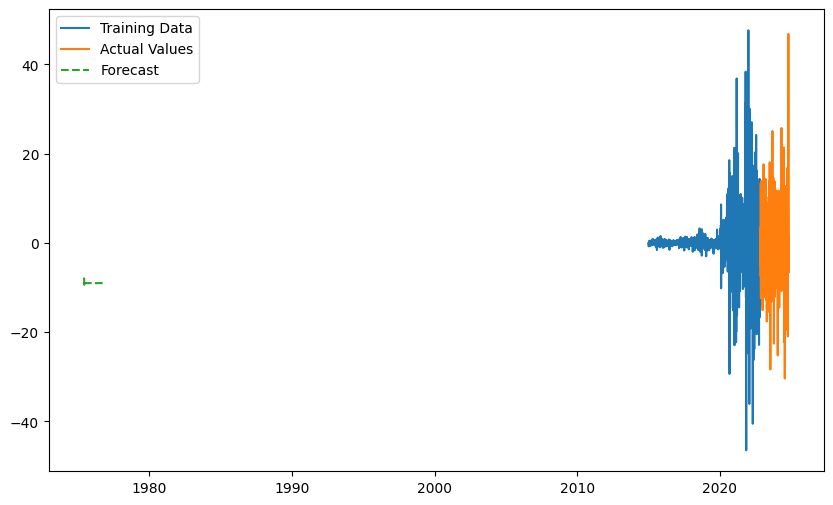

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle

# Split the data into training and testing sets
train_size = int(0.8 * len(tsla_data_diff))
train_data, test_data = tsla_data_diff[0:train_size], tsla_data_diff[train_size:len(tsla_data_diff)]

# Build the ARIMA model
model_arima = ARIMA(train_data, order=(5,1,0))
model_arima_fit = model_arima.fit()

# Save the ARIMA model
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_arima_fit, f)

# Generate forecasts for the test data
forecast_arima = model_arima_fit.forecast(steps=len(test_data))

# Evaluate the model
mae_arima = mean_absolute_error(test_data, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test_data, forecast_arima))
mape_arima = mean_absolute_percentage_error(test_data, forecast_arima)

print('ARIMA Model Metrics:')
print('MAE: ', mae_arima)
print('RMSE: ', rmse_arima)
print('MAPE: ', mape_arima)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Actual Values')
plt.plot(forecast_arima, label='Forecast', linestyle='--')
plt.legend()
plt.show()

Epoch 1/50
1918/1918 - 49s - 26ms/step - loss: 31.0249
Epoch 2/50
1918/1918 - 43s - 23ms/step - loss: 30.8887
Epoch 3/50
1918/1918 - 44s - 23ms/step - loss: 30.7428
Epoch 4/50
1918/1918 - 46s - 24ms/step - loss: 30.6629
Epoch 5/50
1918/1918 - 46s - 24ms/step - loss: 30.4866
Epoch 6/50
1918/1918 - 44s - 23ms/step - loss: 30.7537
Epoch 7/50
1918/1918 - 44s - 23ms/step - loss: 30.1797
Epoch 8/50
1918/1918 - 43s - 23ms/step - loss: 29.7725
Epoch 9/50
1918/1918 - 56s - 29ms/step - loss: 29.1270
Epoch 10/50
1918/1918 - 50s - 26ms/step - loss: 29.0422
Epoch 11/50
1918/1918 - 54s - 28ms/step - loss: 27.2060
Epoch 12/50
1918/1918 - 57s - 30ms/step - loss: 27.9247
Epoch 13/50
1918/1918 - 52s - 27ms/step - loss: 26.6313
Epoch 14/50
1918/1918 - 56s - 29ms/step - loss: 25.7052
Epoch 15/50
1918/1918 - 54s - 28ms/step - loss: 25.3518
Epoch 16/50
1918/1918 - 47s - 24ms/step - loss: 24.2090
Epoch 17/50
1918/1918 - 47s - 24ms/step - loss: 22.6439
Epoch 18/50
1918/1918 - 46s - 24ms/step - loss: 21.8051
E

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
LSTM Model Metrics:
MAE:  7.241829966334091
RMSE:  9.434982742753434
MAPE:  4.109628113428151


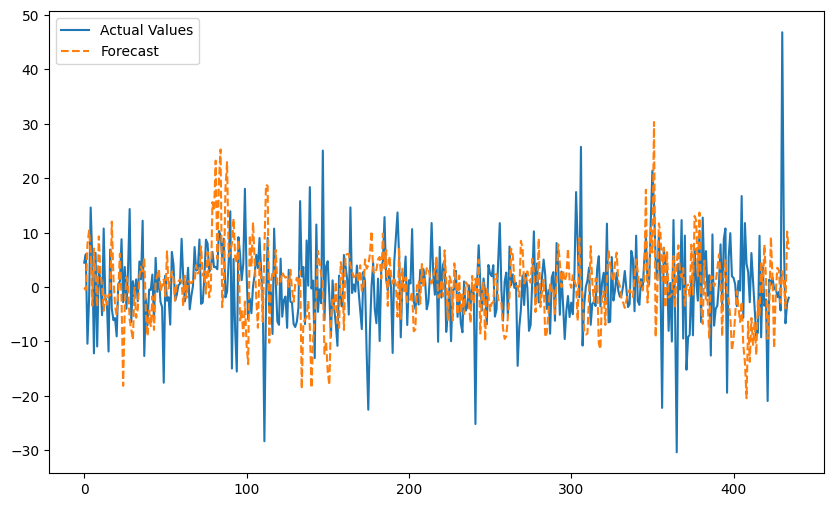

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
# Reshape the data for LSTM
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i])

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i])
    y_test.append(test_data[i])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))

# Compile the model
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
model_lstm.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# Save the LSTM model
model_lstm.save('lstm_model.h5')

# Generate forecasts for the test data
forecast_lstm = model_lstm.predict(X_test)

# Evaluate the model
mae_lstm = mean_absolute_error(y_test, forecast_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, forecast_lstm))
mape_lstm = mean_absolute_percentage_error(y_test, forecast_lstm)

print('LSTM Model Metrics:')
print('MAE: ', mae_lstm)
print('RMSE: ', rmse_lstm)
print('MAPE: ', mape_lstm)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Values')
plt.plot(forecast_lstm, label='Forecast', linestyle='--')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Load cleaned dataset
file_path = '../data/cleaned_TSLA_data.csv'
tsla_data = pd.read_csv(file_path)

# Convert 'Date' to datetime format and set it as index if needed for time series
tsla_data['Date'] = pd.to_datetime(tsla_data['Date'])
tsla_data.set_index('Date', inplace=True)

# Display the first few rows of the dataset
print("Sample data:")
display(tsla_data.head())

# Check for missing values
missing_values = tsla_data.isnull().sum()
print("\nMissing Values Count:")
print(missing_values)

# Summary statistics to identify any extreme values
print("\nSummary Statistics:")
display(tsla_data.describe())

# Plot histograms for each numerical column to understand distributions
tsla_data.hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Columns")
plt.show()

# Box plot for each numerical column to visually inspect outliers
numerical_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
tsla_data[numerical_columns].plot(kind='box', subplots=True, layout=(2, 3), figsize=(15, 10), title="Box Plots for Outlier Detection")
plt.suptitle("Box Plots of Numerical Columns")
plt.show()

# Optional: Detect outliers using Z-score method
z_scores = tsla_data[numerical_columns].apply(zscore)
outliers = (z_scores.abs() > 3).sum()  # Threshold Z-score > 3
print("\nOutliers Count (Z-score > 3):")
print(outliers)


In [ ]:
preprocess_and_explore_data('../data/cleaned_TSLA_data.csv', '../data/Preprocessed_TSLA_data.csv')